In [1]:
!pip install --upgrade keras_applications==1.0.6 keras==2.2.4

    100% |████████████████████████████████| 51kB 64.7MB/s ta 0:00:01
    100% |████████████████████████████████| 317kB 104.2MB/s ta 0:00:01
    100% |████████████████████████████████| 20.0MB 102.0MB/s ta 0:00:016kB 75.9MB/s eta 0:00:01B/s eta 0:00:01   49% |███████████████▊                | 9.8MB 96.9MB/s eta 0:00:01�██████████████▋         | 14.2MB 95.3MB/s eta 0:00:01��████ | 19.4MB 107.3MB/s eta 0:00:01
    100% |████████████████████████████████| 2.9MB 101.4MB/s ta 0:00:01�████                       | 798kB 103.7MB/s eta 0:00:01
    100% |████████████████████████████████| 51kB 78.3MB/s ta 0:00:01
    100% |████████████████████████████████| 266kB 104.6MB/s ta 0:00:01
    100% |████████████████████████████████| 25.2MB 58.4MB/s ta 0:00:011                  | 6.0MB 78.4MB/s eta 0:00:01B/s eta 0:00:01██████            | 15.7MB 107.2MB/s eta 0:00:01�█████████████▋        | 18.6MB 106.2MB/s eta 0:00:01.6MB/s eta 0:00:01�█████████████████████   | 22.8MB 106.3MB/s eta 0:00:01
  Running setup

In [2]:
import os
if os.path.exists('./data') == False:
    from modelarts.session import Session
    session = Session()
    
    if session.region_name == 'cn-north-1':
        bucket_path="modelarts-labs/end2end/image_recognition/dog_and_cat_25000.tar.gz"
    elif session.region_name == 'cn-north-4':
        bucket_path="modelarts-labs-bj4/end2end/image_recognition/dog_and_cat_25000.tar.gz"
    else:
        print("请更换地区到北京一或北京四")

    session.download_data(
        bucket_path=bucket_path,
        path="./dog_and_cat_25000.tar.gz")

    # 使用tar命令解压资源包
    !tar xf ./dog_and_cat_25000.tar.gz

    # 清理压缩包
    !rm -f ./dog_and_cat_25000.tar.gz

Successfully download file modelarts-labs/end2end/image_recognition/dog_and_cat_25000.tar.gz from OBS to local ./dog_and_cat_25000.tar.gz


In [3]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

from keras.applications.mobilenetv2 import MobileNetV2
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.models import load_model

from keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image

Using TensorFlow backend.
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

In [4]:
def load_data():
    dirname = "./data"
    path = "./data"

    num_train_samples = 25000

    x_train = np.empty((num_train_samples, 224,224,3), dtype='uint8')
    y_train = np.empty((num_train_samples,1), dtype='uint8')
    index = 0
    for file in os.listdir("./data"):
        image = Image.open(os.path.join(dirname,file)).resize((224,224))
        image = np.array(image)
        x_train[index,:,:,:] = image

        if "cat" in file:
            y_train[index,0] =1
        elif "dog" in file:
            y_train[index,0] =0

        index += 1
    return (x_train, y_train)

In [5]:
(x_train, y_train) = load_data()
print(x_train.shape)
print(y_train.shape)

(25000, 224, 224, 3)
(25000, 1)


In [6]:
from keras.utils import np_utils
def process_data(x_train,y_train):
    x_train = x_train.astype(np.float32)
    x_train /= 255
    n_classes = 2
    y_train = np_utils.to_categorical(y_train, n_classes)
    return x_train,y_train

In [7]:
x_train,y_train= process_data(x_train,y_train)
print(x_train.shape)
print(y_train.shape)

(25000, 224, 224, 3)
(25000, 2)


In [8]:
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    print(type(model))
    return model

In [9]:
base_model = VGG16(weights=None, include_top=False)

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
model = build_model(base_model)
model.summary()

<class 'keras.engine.training.Model'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, No

In [11]:
import keras 
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# rmsprop优化器

In [12]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [13]:
es = EarlyStopping(monitor='val_acc', baseline=0.9, patience=30, verbose=1, mode='auto')
callbacks = [es]

In [14]:
history_rmsprop = model.fit(x=x_train, 
                  y=y_train, 
                  batch_size=32, 
                  epochs=31, 
                  verbose=1, 
                  callbacks=callbacks, 
                  validation_split=0.25, 
                  shuffle=True, 
                  initial_epoch=0, 
                 )

Instructions for updating:
Use tf.cast instead.


Train on 18750 samples, validate on 6250 samples
Epoch 1/31
18750/18750 [==============================] - 176s 9ms/step - loss: 0.6772 - acc: 0.5924 - val_loss: 0.6308 - val_acc: 0.6346
Epoch 2/31
18750/18750 [==============================] - 149s 8ms/step - loss: 0.6235 - acc: 0.6561 - val_loss: 0.5850 - val_acc: 0.6944
Epoch 3/31
18750/18750 [==============================] - 149s 8ms/step - loss: 0.5665 - acc: 0.7139 - val_loss: 0.5086 - val_acc: 0.7586
Epoch 4/31
18750/18750 [==============================] - 149s 8ms/step - loss: 0.5118 - acc: 0.7568 - val_loss: 0.4787 - val_acc: 0.7814
Epoch 5/31
18750/18750 [==============================] - 149s 8ms/step - loss: 0.4605 - acc: 0.7890 - val_loss: 0.4258 - val_acc: 0.8053
Epoch 6/31
18750/18750 [==============================] - 151s 8ms/step - loss: 0.4143 - acc: 0.8164 - val_loss: 0.3873 - val_acc: 0.8230
Epoch 7/31
18750/18750 [==============================] - 150s 8ms/step - loss: 0.3634 - acc: 0.8402 - val_loss: 0.3332 - v

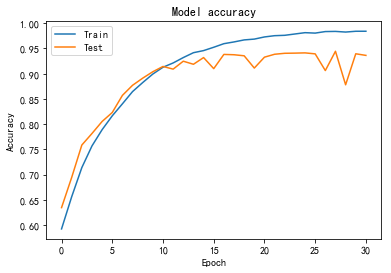

In [15]:
# 绘制训练 & 验证的准确率值
plt.plot(history_rmsprop.history['acc'])
plt.plot(history_rmsprop.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

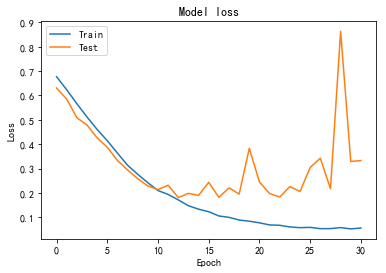

In [16]:
# 绘制训练 & 验证的损失值
plt.plot(history_rmsprop.history['loss'])
plt.plot(history_rmsprop.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Adam优化器

In [17]:
base_model = VGG16(weights=None, include_top=False)
model_adam = build_model(base_model)
opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)
model_adam.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

<class 'keras.engine.training.Model'>


In [18]:
history_adam = model_adam.fit(x=x_train, 
                  y=y_train, 
                  batch_size=32, 
                  epochs=31, 
                  verbose=1, 
                  callbacks=callbacks, 
                   validation_split=0.25,  
                  shuffle=True, 
                  initial_epoch=0
                 )

Train on 18750 samples, validate on 6250 samples
Epoch 1/31
18750/18750 [==============================] - 156s 8ms/step - loss: 0.6931 - acc: 0.5063 - val_loss: 0.6933 - val_acc: 0.4968
Epoch 2/31
18750/18750 [==============================] - 154s 8ms/step - loss: 0.6886 - acc: 0.5349 - val_loss: 0.6833 - val_acc: 0.5645
Epoch 3/31
18750/18750 [==============================] - 154s 8ms/step - loss: 0.6609 - acc: 0.5978 - val_loss: 0.6289 - val_acc: 0.6405
Epoch 4/31
18750/18750 [==============================] - 154s 8ms/step - loss: 0.5903 - acc: 0.6838 - val_loss: 0.5691 - val_acc: 0.7050
Epoch 5/31
18750/18750 [==============================] - 155s 8ms/step - loss: 0.5348 - acc: 0.7327 - val_loss: 0.5175 - val_acc: 0.7478
Epoch 6/31
18750/18750 [==============================] - 154s 8ms/step - loss: 0.4941 - acc: 0.7611 - val_loss: 0.5113 - val_acc: 0.7526
Epoch 7/31
18750/18750 [==============================] - 154s 8ms/step - loss: 0.4580 - acc: 0.7858 - val_loss: 0.4280 - v

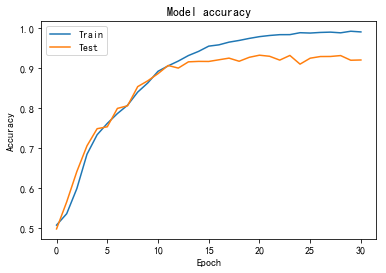

In [19]:
# 绘制训练 & 验证的准确率值
plt.plot(history_adam.history['acc'])
plt.plot(history_adam.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

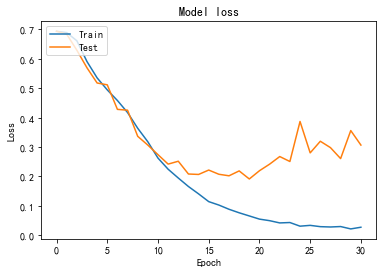

In [20]:
# 绘制训练 & 验证的损失值
plt.plot(history_adam.history['loss'])
plt.plot(history_adam.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# SGD优化器

In [21]:
base_model = VGG16(weights=None, include_top=False)
model_sgd = build_model(base_model)
opt = keras.optimizers.SGD(lr=0.0001, decay=1e-6)
model_sgd.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

<class 'keras.engine.training.Model'>


In [22]:
history_sgd = model_sgd.fit(x=x_train, 
                  y=y_train, 
                  batch_size=32, 
                  epochs=31, 
                  verbose=1, 
                  callbacks=callbacks, 
                  validation_split=0.25,
                  shuffle=True, 
                  initial_epoch=0, 
                 )

Train on 18750 samples, validate on 6250 samples
Epoch 1/31
18750/18750 [==============================] - 155s 8ms/step - loss: 0.6931 - acc: 0.5011 - val_loss: 0.6931 - val_acc: 0.4968
Epoch 2/31
18750/18750 [==============================] - 153s 8ms/step - loss: 0.6931 - acc: 0.5011 - val_loss: 0.6931 - val_acc: 0.4968
Epoch 3/31
18750/18750 [==============================] - 153s 8ms/step - loss: 0.6931 - acc: 0.5011 - val_loss: 0.6931 - val_acc: 0.4968
Epoch 4/31
18750/18750 [==============================] - 151s 8ms/step - loss: 0.6931 - acc: 0.5011 - val_loss: 0.6931 - val_acc: 0.4968
Epoch 5/31
18750/18750 [==============================] - 152s 8ms/step - loss: 0.6931 - acc: 0.5011 - val_loss: 0.6931 - val_acc: 0.4968
Epoch 6/31
18750/18750 [==============================] - 152s 8ms/step - loss: 0.6931 - acc: 0.5011 - val_loss: 0.6931 - val_acc: 0.4968
Epoch 7/31
18750/18750 [==============================] - 152s 8ms/step - loss: 0.6931 - acc: 0.5011 - val_loss: 0.6931 - v

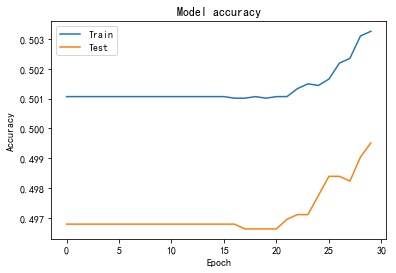

In [23]:
# 绘制训练 & 验证的准确率值
plt.plot(history_sgd.history['acc'])
plt.plot(history_sgd.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

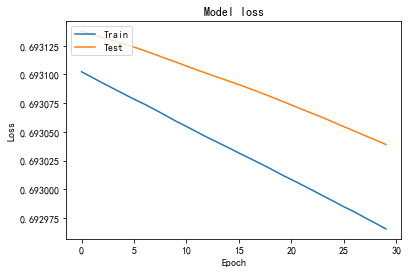

In [24]:
# 绘制训练 & 验证的损失值
plt.plot(history_sgd.history['loss'])
plt.plot(history_sgd.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()